Import tools and define files

In [1]:
import argparse
import itertools
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from bs4 import BeautifulSoup
from pygmlparser.Parser import Parser as GmlParser

EDGELIST = 'umdEdges.csv'
NODELIST = 'umdPOI.csv'
OUTPUT_CSV = 'short_graph.csv'
OUTPUT_GML = 'short_graph.gml'
OUTPUT_KML = 'short_graph.kml'

In [2]:
def create_complete_graph(pair_weights, flip_weights=True):
    '''create a complete graph from the pair weights'''
    graph = nx.Graph()
    for k, v in pair_weights.items():
        wt_i = -v if flip_weights else v
        graph.add_edge(k[0], k[1], weight=wt_i)
    return graph

In [3]:
def get_shortest_paths_distance(graph, pairs, edge_weight_name='weight'):
    '''get the shortest path distances between all pairs of nodes'''
    distances = {}
    for pair in pairs:
        distances[pair] = nx.dijkstra_path_length(graph, pair[0], pair[1], weight=edge_weight_name)
    return distances

In [4]:
edgelist = pd.read_csv(EDGELIST)
nodelist = pd.read_csv(NODELIST)

graph=nx.Graph()
for _, elrow in edgelist.iterrows():
    graph.add_edge(elrow[0], elrow[1], weight = elrow[2])

for _, nlrow in nodelist.iterrows():
    graph.add_node(nlrow[0], attr_dict=nlrow[1:].to_dict())

node_positions = {}
for node in graph.nodes(data=True):
    node_positions[node[0]] = (node[1]['attr_dict']['longitude'],
                               node[1]['attr_dict']['latitude'])

In [5]:
nodes_odd_degree = [v for v, d in graph.degree() if d % 2 == 1]

In [6]:
odd_node_pairs = list(itertools.combinations(nodes_odd_degree, 2))

In [7]:
odd_node_pairs_shortest_paths = get_shortest_paths_distance(graph, odd_node_pairs, 'weight')

In [8]:
g_odd_complete = create_complete_graph(odd_node_pairs_shortest_paths, flip_weights=True)

In [9]:
odd_matching_dupes = nx.algorithms.max_weight_matching(g_odd_complete, True)
odd_matching = list(pd.unique([tuple(sorted([k,v])) for k, v in odd_matching_dupes]))

<Figure size 800x600 with 0 Axes>

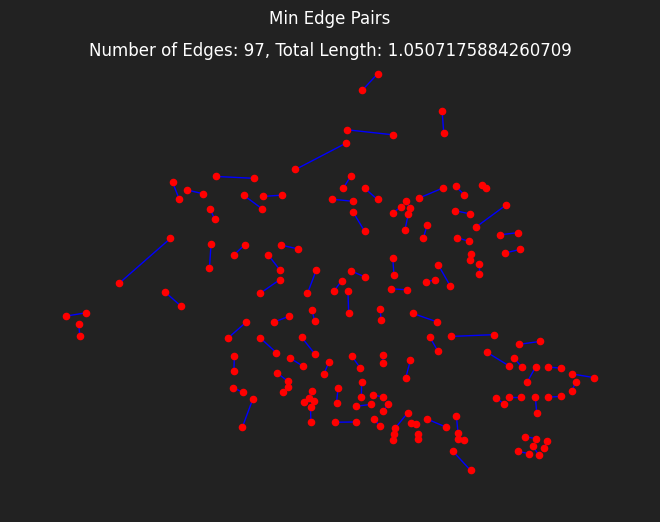

In [102]:
g_odd_complete_min_edges = nx.Graph(odd_matching_dupes)

# print(g_odd_complete_min_edges.edges())
#print(odd_node_pairs_shortest_paths)

min_pairs_total_length=0
for pair in g_odd_complete_min_edges.edges():
    if(pair[1],pair[0]) in odd_node_pairs_shortest_paths.keys():
        min_pairs_total_length+=odd_node_pairs_shortest_paths[(pair[1],pair[0])]
    #print((pair[1],pair[0]) in odd_node_pairs_shortest_paths.keys())

#min_pairs_total_length = sum(int(odd_node_pairs_shortest_paths[(pair[1], pair[0])]) for pair in g_odd_complete_min_edges.edges() if (pair[1], pair[0]) in odd_node_pairs_shortest_paths.keys())


plt.figure(figsize=(8,6))
fig = plt.figure()
nx.draw(g_odd_complete_min_edges, pos = node_positions, node_size=20, edge_color = 'b', node_color='r')
fig.set_facecolor("#222222")
plt.title("Min Edge Pairs", color='white')
plt.suptitle(F"Number of Edges: {len(odd_matching)}, Total Length: {min_pairs_total_length}", color='white')
plt.show()

<Figure size 800x600 with 0 Axes>

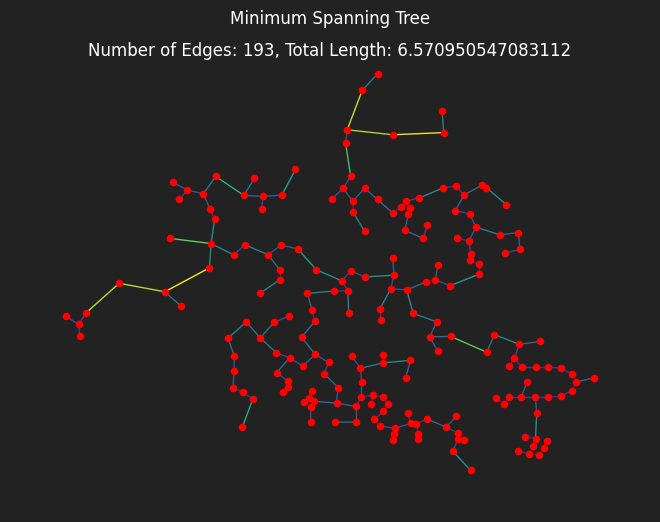

In [81]:
min_graph = nx.minimum_spanning_tree(graph)

min_graph_total_length = sum([d['weight'] for _, _, d in min_graph.edges(data=True)])

plt.figure(figsize=(8,6))
edge_colors = [min_graph[u][v]['weight'] for u,v in min_graph.edges()]
fig = plt.figure()
nx.draw(min_graph, pos = node_positions, node_size=20, edge_color=edge_colors,node_color='r')
fig.set_facecolor('#222222')
plt.title(f"Minimum Spanning Tree", color='white')
plt.suptitle(f"Number of Edges: {min_graph.number_of_edges()}, Total Length: {min_graph_total_length}", color='white')
plt.show()

<Figure size 800x600 with 0 Axes>

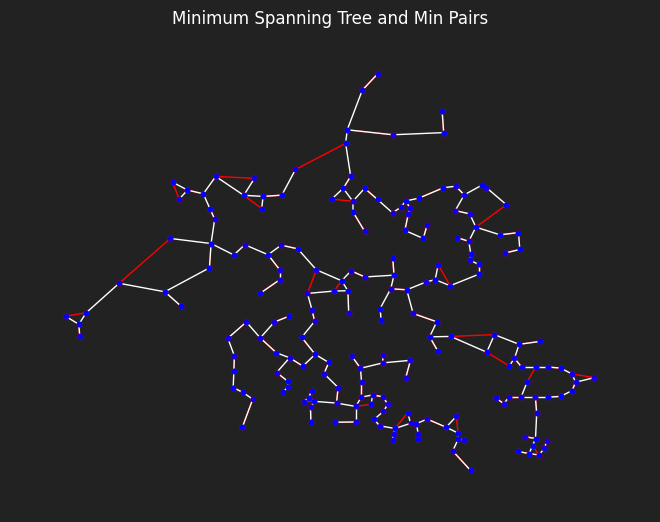

In [104]:
plt.figure(figsize=(8,6))
fig = plt.figure()
nx.draw(g_odd_complete_min_edges, pos=node_positions, node_size=10, node_color='r', edge_color='r', with_labels=False)
nx.draw(min_graph, pos=node_positions, node_size=10, node_color='b', with_labels=False, edge_color='w')
fig.set_facecolor('#222222')
plt.title(f'Minimum Spanning Tree and Min Pairs', color='white')
plt.suptitle
plt.show()

213
213


<Figure size 800x600 with 0 Axes>

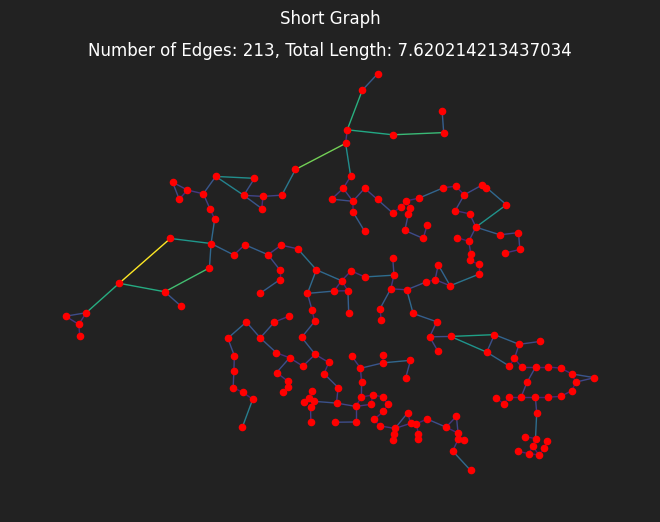

In [89]:
short_graph = nx.Graph()
for node in min_graph.nodes():
    short_graph.add_node(node, attr_dict=graph.nodes[node]['attr_dict'])
for edge in min_graph.edges():
    short_graph.add_edge(edge[0], edge[1], weight=graph.edges[edge]['weight'])
for edge in g_odd_complete_min_edges.edges():
    if (edge not in short_graph.edges()) & ((edge[1], edge[0]) not in short_graph.edges()):
        short_graph.add_edge(edge[0], edge[1], weight=graph.edges[edge]['weight'])



short_graph_total_length = sum([d['weight'] for _, _, d in short_graph.edges(data=True)])
# print(short_graph_total_length)

plt.figure(figsize=(8,6))
#create a range for edge colors based on the weights from blue to red
edge_colors = [short_graph[u][v]['weight'] for u,v in short_graph.edges()]
print(len(edge_colors))
print(short_graph.number_of_edges())
fig = plt.figure()
nx.draw(short_graph, pos = node_positions, node_size=20, edge_color = edge_colors, node_color='r')
fig.set_facecolor("#222222")
plt.title(f"Short Graph", color='white')
plt.suptitle(f"Number of Edges: {short_graph.number_of_edges()}, Total Length: {short_graph_total_length}", color='white')
plt.show()

In [43]:
nx.write_gml(short_graph, OUTPUT_GML, repr)

In [69]:
with open(OUTPUT_GML, 'r', encoding='utf-8') as file:
    data = file.readlines()
short_nodes = []
short_edges = []
for i in range(0, len(data)):
    if data[i] == '  node [\n':
        id = int(data[i+1].strip().split(' ')[1])
        label = data[i+2].strip()[8:-2]#.replace('&#38;', '&')
        long = float(data[i+4].strip().split(' ')[1])
        lat = float(data[i+5].strip().split(' ')[1])
        short_nodes.append((label, long, lat))

    if data[i] == '  edge [\n':
        source = short_nodes[int(data[i+1].strip().split(' ')[1])]
        target = short_nodes[int(data[i+2].strip().split(' ')[1])]
        short_edges.append((source, target))

Generate the text for a kml file

In [70]:
with open(OUTPUT_KML, 'w', encoding='utf-8') as file:
    file.write("<?xml version=\"1.0\" encoding=\"UTF-8\"?>\n<kml xmlns=\"http://www.opengis.net/kml/2.2\">\n<Document>\n")
    file.write("<Style id=\"icon-blue-dot\"><LabelStyle><scale>.6</scale><color>ff00ffff</color></LabelStyle><IconStyle><scale>.3</scale><Icon><href>https://icones.pro/wp-content/uploads/2021/04/icone-cercle-rempli-bleu.png</href></Icon></IconStyle></Style>")
    for node in short_nodes:
        file.write(
        f'''<Placemark>
            <name>{node[0]}</name>
            <styleUrl>#icon-blue-dot</styleUrl>
            <Point>
                <coordinates>
                    {node[1]},{node[2]},0
                </coordinates>
            </Point>
        </Placemark>
        ''')
    for edge in short_edges:
        file.write(f'''<Placemark>
        <Style>
            <LineStyle>
                <color>#ff0000ff</color>
                <width>4</width>
            </LineStyle></Style>
            <LineString>
                <coordinates>
                    {edge[0][1]},{edge[0][2]},0
                    {edge[1][1]},{edge[1][2]},0
                </coordinates>
            </LineString>
        </Placemark>
        ''')
    file.write("</Document>\n</kml>")